# Deep Q-Learning DQN

 In this homework we will implement DQN for frozn lake environment

## Q-Learning Algorithm

Q-learning is an algorithm that repeatedly adjusts Q Value to minimize the Bellman error.
$$Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \underbrace{\left [ r(s,a) + \gamma \max_{a'} Q(s_{t+1},a') - Q(s_t,a_t) \right ]}_{\text{Bellman Error}}$$

The Q-value function at state s and action a, is the expected cumulative reward from taking action a in state s and then following the policy:
$$Q(s,a) = \mathbb{E} \left [ \sum_{t \geq 0} \gamma^t r_t \right ]$$

We learn these Q-values using the Q-learning algorithm.<br>

The discount factor $\gamma$ is the weight for future rewards.<br>

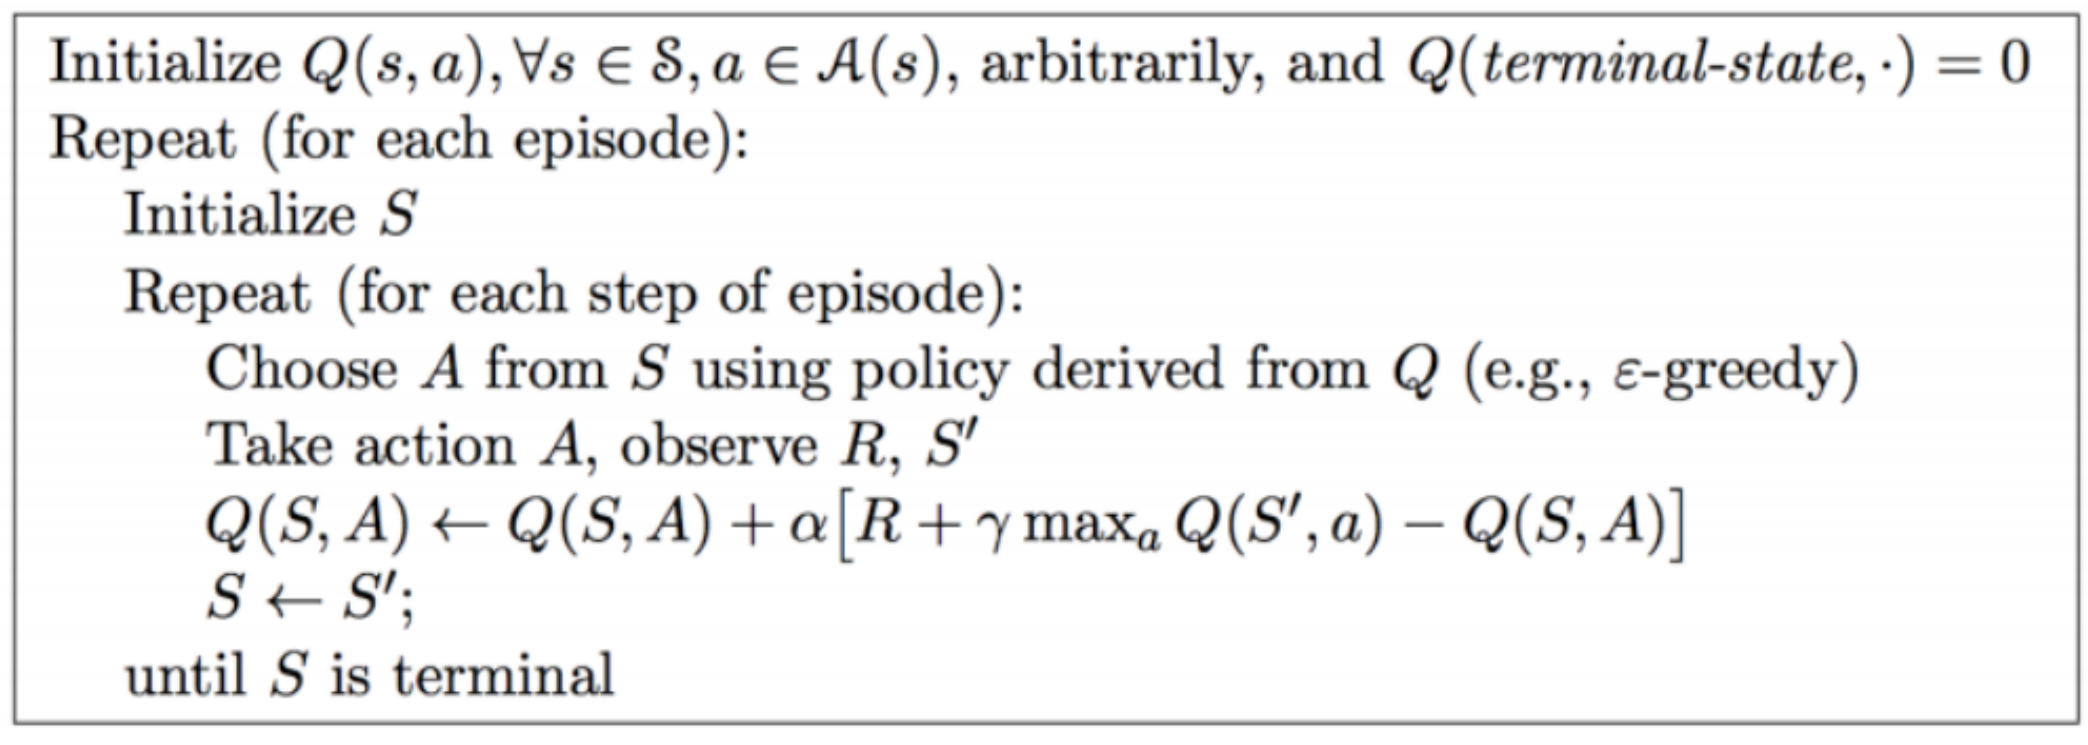

In [1]:
import numpy as np
import gym
import random
import matplotlib.pyplot as plt

In [2]:
# Create the environment
env = gym.make("FrozenLake-v1", is_slippery=False, new_step_api=True)
# env = gym.make("FrozenLake-v1", render_mode='rgb_array')
env.reset()

0

/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


None


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


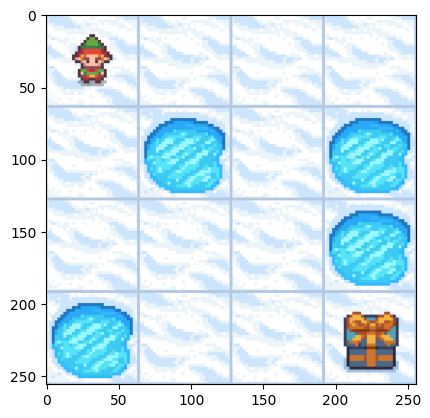

In [3]:
# Use a global plot to support live rendering
FIG, AX = plt.subplots()
print(env.render())
IMG = AX.imshow(env.render(mode='rgb_array'))
plt.show(block=False)

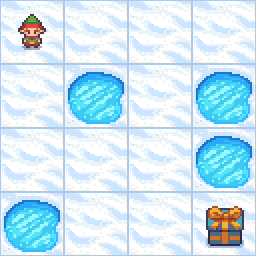

In [4]:
from IPython import display
from PIL import Image
display.clear_output(wait=True)
display.display(Image.fromarray(env.render(mode='rgb_array')))

## Import libraries

In [5]:
import numpy as np
import gym
import random
from datetime import datetime
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import namedtuple, deque
import os
import glob
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from IPython import display as ipythondisplay

from typing import Tuple
import matplotlib

## Using GPU

In [6]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using \"{DEVICE}\" device.")

Using "cuda" device.


## Creating Environment

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


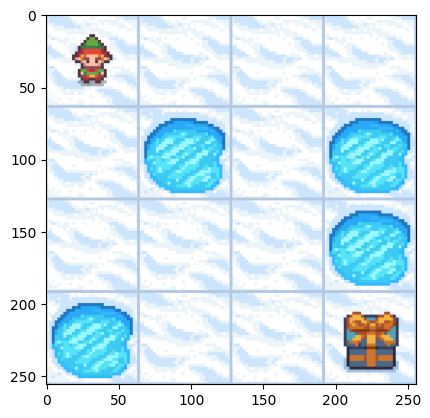

In [7]:
# Render_mode set to rgb_array to allow dqn network to run on images
env = gym.make("FrozenLake-v1", is_slippery=False, new_step_api=True)
env.reset()

# Use a global plot to support live rendering
# FIG, AX = plt.subplots()
# print(env.render())
# IMG = AX.imshow(env.render(mode='rgb_array'))
IMG = env.render(mode='rgb_array')
plt.imshow(IMG)
plt.show()

## Visualization & **Seeing**
`render_env`
- This function allow us to see the intermediate process of the training. However, if it is run in Google Colab, the RAM will soon run out. So, it is not actually used in the program. At the very end of this notebook, there is another version of the training part which enables this function.

`render_state`
- The state image is shown. It is also not used in the program for the same reason above. But there is an example image shown in *Hyperparameter* part.

`extract_state_img`
- This is **the most important function** in the whole program. It crops the current image into a smaller one so that the agent can see the environment around it. The reason why doing this is that the agent is truly expected to ***SEE*** the environment around it. The neural network for DQN in this program is based on convolutional neural networks.

In [8]:
def render_env(env, title=None):
    """
    Render environment image.

    :param env: Frozenlake environment

    :return: None
    """

    # if title:
    #     FIG.suptitle(title)

    # IMG.set_data(env.render('rgb_array'))
    # FIG.canvas.draw()
    # FIG.canvas.flush_events()
    # plt.pause(0.1)
    plt.imshow(env.render('rgb_array'))
    plt.axis('off')
    # plt.show()
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

# def render_state(env, state_idx, transforms):
#     """
#     Render state image.

#     :param env: Frozenlake environment
#     :param state_idx: Index of the state, range is 0-15
#     :param transforms: Transform the image before return

#     :return: None
#     """
#     image = extract_state_img(env, state_idx, transforms).permute(1,2,0)
#     plt.imshow(image, cmap='gray')
#     plt.axis('off')
#     ipythondisplay.clear_output(wait=True)
#     ipythondisplay.display(plt.gcf())

def extract_state_img(env, state_idx, transforms):
    """
    Extracts the state image from the environment image.

    :param env: Frozenlake environment
    :param state_idx: Index of the state, range is 0-15
    :param transforms: Transform the image before return

    :return: Image of shape CxHxW
    """
    # Convert env rgb array to tensor
    env = torch.tensor(env.render('rgb_array'))
    block_size = env.shape[0] // 4

    # Extract state from given index
    env = env.permute(2, 0, 1)
    env = transforms(env)
    env = env.permute(1, 2, 0)

    start_idx = (state_idx // 4) * block_size
    end_idx = (state_idx % 4) * block_size
    state_img = env[start_idx:(start_idx + block_size + 2 * PADDING), end_idx:(end_idx + block_size + 2 * PADDING), :]

    # plt.imshow(state_img, cmap='gray')
    # plt.axis('off')

    state_img = state_img.permute(2, 0, 1).type(torch.float)
    return state_img

## Hyperparameters and Constraints
- One of the extracted image example is shown below.
- The image is actually in grayscale to simplify the calculation.


104


(-0.5, 103.5, 103.5, -0.5)

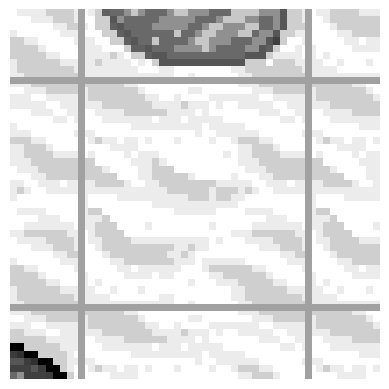

In [9]:
# Constants used throughout the code
ACTION_SPACE_SIZE = env.action_space.n
STATE_SPACE_SIZE = env.observation_space.n

PADDING = 20
TAU = 0.005
GAMMA = 0.99
LR = 1e-3

EPSILON = 1.0
EPS_MAX = 1.0
EPS_MIN = 0.01
EPS_DECAY = 0.003

UPDATE_FREQ = 5
TRAIN_EPOCHS = 1

TRANSFORMS = torchvision.transforms.Compose([
    torchvision.transforms.Pad(padding=PADDING, fill=255),
    torchvision.transforms.Grayscale(1),
    torchvision.transforms.Lambda(lambda x: x/255.0),
])

IMG_WIDTH = extract_state_img(env, state_idx=9, transforms=TRANSFORMS).shape[1]
EXAMPLE_IMG = extract_state_img(env, state_idx=9, transforms=TRANSFORMS)

print(IMG_WIDTH)
EXAMPLE_IMG = EXAMPLE_IMG.permute(1, 2, 0)
plt.imshow(EXAMPLE_IMG, cmap='gray')
plt.axis('off')

## Replaying Memory
Experience replay memory is used for training the DQN. It stores the transitions that the agent observes, allowing the reusage of this data later. By sampling from it randomly, the transitions that build up a batch are decorrelated. It has been shown that this greatly stabilizes and improves the DQN training procedure.

For this, two classes are needed:

`Transition`
- a named tuple representing a single transition in our environment. It essentially maps (state, action) pairs to their (next_state, reward) result, with the state being the screen difference image as described later on.

`ReplayMemory`
- a cyclic buffer of bounded size that holds the transitions observed recently. It also implements a .sample() method for selecting a random batch of transitions for training.


In [10]:
"""
Replay Memory
"""
Transition = namedtuple('Transition',
                           ('state', 'action', 'reward', 'next_state'))

class ReplayMemory(object):
    def __init__(self, capacity, batch_size):
        self.capacity = capacity
        self.batch_size = batch_size
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self):
        if (len(self.memory) < self.batch_size):
            return None
        return random.sample(self.memory, self.batch_size)

    def __len__(self):
        return len(self.memory)


## DQN Architecture
This part mainly defines the model of DQN. Where input is a grayscale image (with **one** channel this time). And the outputs are actions.

In [11]:
"""
DQN Architecture
"""
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            # 1, 104, 104
            nn.Conv2d(1, 32, kernel_size=8, stride=4),
            nn.ReLU(True),
            # 32, 25, 25
            nn.Conv2d(32, 64, kernel_size=5, stride=2),
            nn.ReLU(True),
            # 64, 11, 11
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(True),
            # 64, 9, 9
            nn.Flatten(),
            nn.Linear(9 * 9 * 64, 512),
            nn.ReLU(True),
            nn.Linear(512, n_actions),
        )

    def forward(self, x):
        return self.model(x)

# **DQN Agent**
Q-learning is an algorithm that repeatedly adjusts Q Value to minimize the Bellman error.
$$Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \underbrace{\left [ r(s,a) + \gamma \max_{a'} Q(s_{t+1},a') - Q(s_t,a_t) \right ]}_{\text{Bellman Error}}$$
As for the DQN, the loss function is comparing the difference between $Q(s_t, a_t)$ and $r(s,a) + \gamma \max_{a'}$, which is exactly the Bellman error. Specifically, the loss function for the neural network is the ***Smooth L1 Loss*** which is also knonw as the ***Huber Loss***.

$$
\left\{
\begin{aligned}
0.5 \cdot (x - y)^2,& \text{if} |x - y| < 1 \\
|x - y| - 0.5,& \text{otherwise}
\end{aligned}
\right.
$$

where:
- ( x ) represents the predicted value (e.g., predicted Q-value in the DQN).
- ( y ) represents the target value (e.g., target Q-value in the DQN).
The Smooth L1 Loss behaves like the L1 loss (MAE) when the absolute difference between ( x ) and ( y ) is small (i.e., $( |x - y| < 1 )$), and it behaves like the L2 loss (MSE) when the absolute difference is large (i.e., $( |x - y| \geq 1 )$). This property makes the loss more robust to outliers and can lead to more stable training in some scenarios.


In [12]:
"""
DQN Agent
"""
class Agent():
    def __init__(self, env, policy_net, target_net, optimizer):
        self.env = env
        self.policy_net = policy_net
        self.target_net = target_net
        self.optimizer = optimizer
        self.memory = ReplayMemory(capacity=10000, batch_size=128)
        self.tau = TAU
        self.gamma = GAMMA
        self.checkpoint_freq = 5000

    def train(self, n_episodes, n_steps, exploration_rate=1.0, resume_training=False, pretrained_model=None):
        """
        Train a model with the following params

        :param n_episodes: Total episodes to train for
        :param n_steps: Total steps or actions before each episode is terminated
        :param save_dir: Directory where model is save at each checkpoint
        :param exploration_rate: Rate between exploration and exploitation
        :param resume_training: Set to True to continue training from last checkpoint saved in save_dir

        :return: None
        """
        if resume_training:
            self.load_model(pretrained_model)

        for episode in range(1, n_episodes + 1):
            # Save model every 5000 episodes
            if (episode > 0 and episode % self.checkpoint_freq == 0):
                self.save_model(episode)

            state = self.env.reset()
            # print(f"Episode: {episode}")
            total_rewards = 0

            for _ in range(n_steps):
                state_img = extract_state_img(self.env, state, transforms=TRANSFORMS).to(DEVICE)

                # Select an action via explore vs exploit
                sample = random.random()
                EPSILON = EPS_MIN + (EPS_MAX - EPS_MIN) * math.exp(-1 * episode * EPS_DECAY)
                if sample > EPSILON or resume_training:
                    with torch.no_grad():
                        action = torch.argmax(self.policy_net(state_img.unsqueeze(dim=0))).item()
                else:
                    action = self.env.action_space.sample()

                # Execute action, observe reward, and store experience
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                total_rewards += reward

                # If done
                # done = terminated or truncated
                if terminated:
                    next_state = None
                #     reward_list.append(1)
                # else:
                #     reward_list.append(0)

                # title = f"Episode:{episode}"
                # render_env(self.env, title)
                self.memory.push(state, action, reward, next_state)

                state = next_state

                # Optimize model
                self.optimize_model()

                # Soft update target network's weights after each 5 episodes
                if episode % UPDATE_FREQ == 0:
                    policy_net_dict = self.policy_net.state_dict()
                    target_net_dict = self.target_net.state_dict()
                    for key in policy_net_dict:
                        target_net_dict[key] = policy_net_dict[key] * self.tau + target_net_dict[key] * (1 - self.tau)
                    self.target_net.load_state_dict(target_net_dict)

                # Done
                if (terminated or truncated):
                    break

            # Print the intermediate result and append the reward
            reward_list.append(total_rewards)
            print(f"Episode {episode}: Reward = {total_rewards}, Epsilon = {EPSILON}")

    def test(self, n_episodes=100, n_steps=10, pretrained_model=None):
        """
        Test a pretrained model

        :param n_episodes: Total episodes to test for
        :param n_steps: Total steps or actions before each episode is terminated
        :param model_dir: Directory where model is saved

        :return: None
        """
        if pretrained_model:
            # Automatically load the latest saved model in the directory
            self.load_model(pretrained_model)

        n_success = 0
        n_failures = 0

        for episode in range(n_episodes):
            state = self.env.reset()

            for step in range(n_steps):
                state_img = extract_state_img(self.env, state, transforms=TRANSFORMS).to(DEVICE)
                action = torch.argmax(self.policy_net(state_img.unsqueeze(dim=0))).item()

                next_state, reward, terminated, truncated, _ = self.env.step(action)

                if (reward > 0):
                    n_success += 1
                # Fails
                elif (reward == 0 and (truncated or terminated)):
                    n_failures += 1

                done = terminated or truncated
                if terminated:
                    next_state = None

                title = f"Episode: {episode}, Step: {step}"
                print(title)
                render_env(self.env, title)
                state = next_state

                if done:
                    break

        print(f"Accuracy: {n_success/n_episodes}")
        print(f"Failures: {n_failures/n_episodes}")
        print(f"Truncations: {(n_episodes - n_success - n_failures)/n_episodes}")

    def optimize_model(self):
        """
        Optimize the model based on loss between policy net and target net

        :params: None
        :return: None
        """
        for _ in range(TRAIN_EPOCHS):
            # Sample random batch of states
            transitions = self.memory.sample()
            if transitions is None:
                return

            batch = Transition(*zip(*transitions))
            reward_batch = torch.tensor([reward for reward in batch.reward]).to(DEVICE)
            action_batch = torch.tensor([action for action in batch.action]).to(DEVICE)
            action_batch = torch.reshape(action_batch, (self.memory.batch_size, 1))

            # Get Q values predicted by the policy net
            current_state_imgs = torch.zeros(size=(len(batch.state), 1, IMG_WIDTH, IMG_WIDTH), dtype=torch.float).to(DEVICE)
            for i, state in enumerate(batch.state):
                current_state_imgs[i] = extract_state_img(self.env, state, transforms=TRANSFORMS)
            predicted_q_values = self.policy_net(current_state_imgs).gather(1, action_batch)

            # Get Q values predicted by the target net
            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=DEVICE, dtype=torch.bool)
            non_final_next_states = torch.tensor([s for s in batch.next_state if s is not None]).to(DEVICE)
            next_state_imgs = torch.zeros(size=(len(non_final_next_states), 1, IMG_WIDTH, IMG_WIDTH), dtype=torch.float).to(DEVICE)
            for i, state in enumerate(non_final_next_states):
                next_state_imgs[i] = extract_state_img(self.env, state, transforms=TRANSFORMS)

            expected_q_values = torch.zeros(size=(len(batch.state),)).to(DEVICE)

            with torch.no_grad():
                expected_q_values[non_final_mask] = self.target_net(next_state_imgs).max(1)[0]

            expected_q_values = (expected_q_values * self.gamma) + reward_batch
            expected_q_values = expected_q_values.unsqueeze(1)

            # Compute loss
            criterion = nn.SmoothL1Loss()
            loss = criterion(predicted_q_values, expected_q_values)

            # Optimize model
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
            self.optimizer.step()

    def save_model(self, checkpoint_num):
        """
        Save a model

        :param checkpoint_num: Include a checkpoint number in the model's name

        :return: None
        """
        # Set up path
        timestamp = int(datetime.now().timestamp())
        filename = "model_" + str(checkpoint_num) + ".pt"
        path = os.path.join('/content/drive/MyDrive/Frozen_lake', filename)

        # Save state dicts for policy and target net
        torch.save({
            'policy_net_state_dict': self.policy_net.state_dict(),
            'target_net_state_dict': self.target_net.state_dict(),
            'optim_state_dict': self.optimizer.state_dict(),
        }, path)

    def load_model(self, filename):
        """
        Load a model

        :param dir: Directory where the model is saved

        :return: None
        """

        # Load model
        state_dicts = torch.load(filename, map_location=DEVICE)
        self.policy_net.load_state_dict(state_dicts['policy_net_state_dict'])
        self.target_net.load_state_dict(state_dicts['target_net_state_dict'])
        self.optimizer.load_state_dict(state_dicts['optim_state_dict'])

        # Put models in eval mode
        self.policy_net.eval()
        self.target_net.eval()

    def show_matrix(self, pretrained_model):
      self.load_model(pretrained_model)
      matrix = self.policy_net.state_dict()
      print(matrix)

## Network Settings

In [13]:
# DQN Networks
policy_net = DQN(IMG_WIDTH * IMG_WIDTH, ACTION_SPACE_SIZE).to(DEVICE)
target_net = DQN(IMG_WIDTH * IMG_WIDTH, ACTION_SPACE_SIZE).to(DEVICE)
optimizer = torch.optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
target_net.load_state_dict(policy_net.state_dict())

reward_list = []

## Training
- The first parameter is for the episode size, usually 1400 is more than enough that the agent already reaches 100% accurancy.
- The second parameter is the timestep limitation.

In [14]:
# Initialize
env.reset()
dqn_trainer = Agent(env, policy_net, target_net, optimizer)

In [15]:
# Train
train_episode = 1000
dqn_trainer.train(train_episode, 10, resume_training=False)

Episode 1: Reward = 0.0, Epsilon = 0.9970344505483393
Episode 2: Reward = 0.0, Epsilon = 0.9940777844133959
Episode 3: Reward = 0.0, Epsilon = 0.9911299749851548
Episode 4: Reward = 0.0, Epsilon = 0.9881909957333113
Episode 5: Reward = 0.0, Epsilon = 0.985260820207032
Episode 6: Reward = 0.0, Epsilon = 0.9823394220347178
Episode 7: Reward = 0.0, Epsilon = 0.979426774923765
Episode 8: Reward = 0.0, Epsilon = 0.9765228526603302
Episode 9: Reward = 0.0, Epsilon = 0.9736276291090934
Episode 10: Reward = 0.0, Epsilon = 0.970741078213023
Episode 11: Reward = 0.0, Epsilon = 0.9678631739931417
Episode 12: Reward = 0.0, Epsilon = 0.9649938905482919
Episode 13: Reward = 0.0, Epsilon = 0.962133202054903
Episode 14: Reward = 0.0, Epsilon = 0.9592810827667597
Episode 15: Reward = 0.0, Epsilon = 0.9564375070147689
Episode 16: Reward = 0.0, Epsilon = 0.9536024492067297
Episode 17: Reward = 0.0, Epsilon = 0.9507758838271028
Episode 18: Reward = 0.0, Epsilon = 0.9479577854367803
Episode 19: Reward = 0.

## Visualizing the loss

Text(0, 0.5, 'Reward')

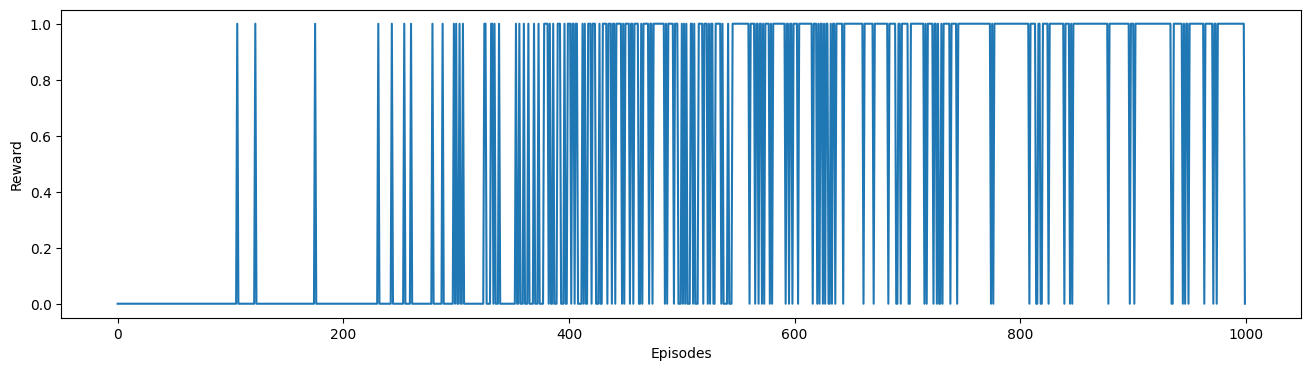

In [19]:
plt.figure(figsize=(16,4))
plt.plot(reward_list)
plt.xlabel("Episodes")
plt.ylabel("Reward")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Reward')

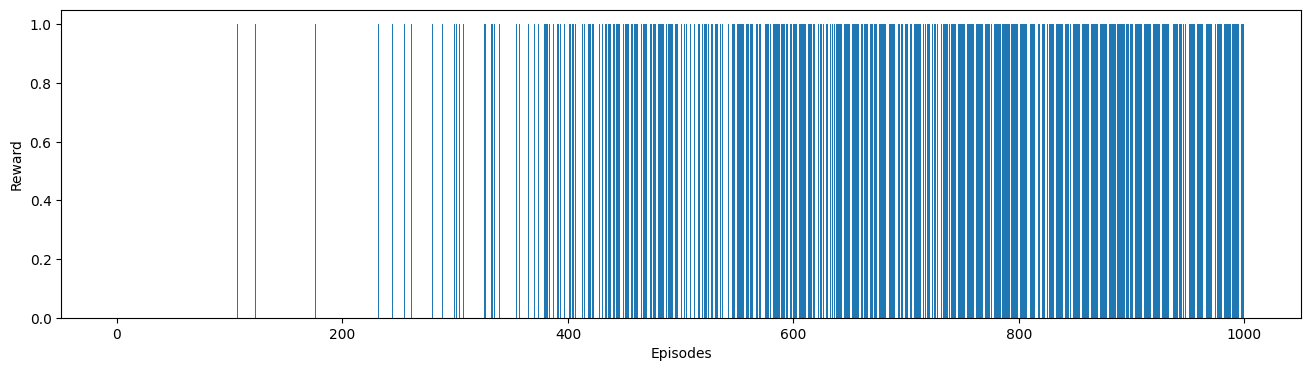

In [20]:
plt.figure(figsize=(16,4))
x = range(1, train_episode + 1)
plt.bar(x, reward_list)
plt.xlabel("Episodes")
plt.ylabel("Reward")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


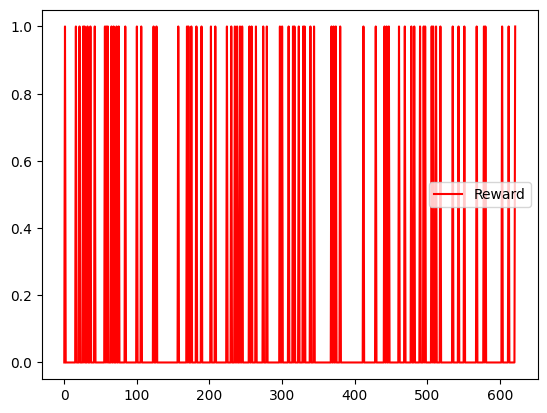

In [ ]:
x = list(range(len(reward_list)))
plt.plot(x, reward_list, 'r')
plt.legend(['Reward'])
plt.show()
# print(reward_list)

## Testing
- The `pretrained_model` part should be modified to suit the files.

In [ ]:
# The path of model
path = '/content/drive/MyDrive/Frozen_lake/model_2000.pt'

In [ ]:
# Show the policy matrix
dqn_trainer.show_matrix(pretrained_model=path)

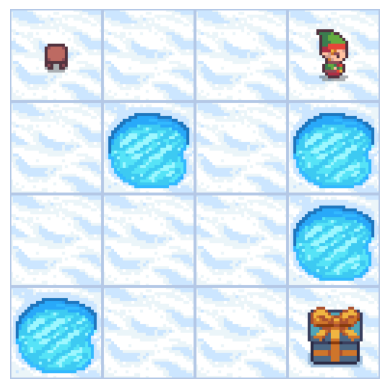

In [ ]:
# Test
dqn_trainer.test(n_episodes=10, n_steps=20, pretrained_model=path)

## Random map testing

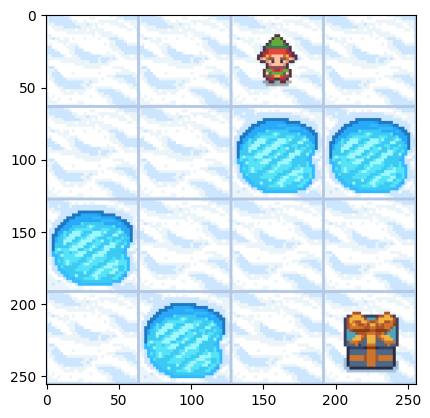

In [ ]:
# Creating new environment
env_new = gym.make("FrozenLake-v1", is_slippery=False, new_step_api=True, desc=["FFSF", "FFHH", "HFFF", "FHFG"])
env_new.reset()

# Use a global plot to support live rendering
FIG, AX = plt.subplots()
# print(env_new.render())
IMG = AX.imshow(env_new.render(mode='rgb_array'))
plt.show(block=False)

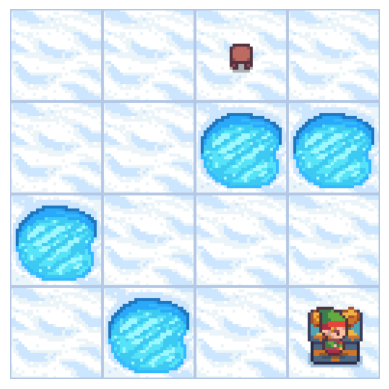

Accuracy: 1.0
Failures: 0.0
Truncations: 0.0


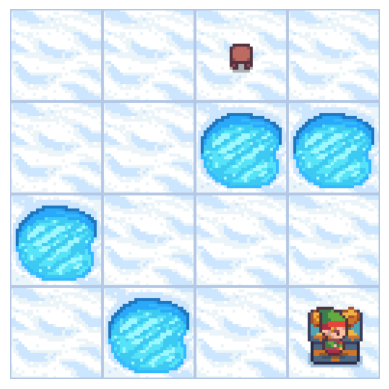

In [ ]:
dqn_random = Agent(env_new, policy_net, target_net, optimizer)
# The path of model
path = '/content/drive/MyDrive/Frozen_lake_models/model_1960_1690460761.pt'
# Test
dqn_random.test(n_episodes=3, n_steps=20, pretrained_model=path)

## The training codes with realtime visualization
***But this runs extremely slow!!!***
The codes that are uncommended is on line 62.

In [ ]:
"""
DQN Agent
"""
class Agent():
    def __init__(self, env, policy_net, target_net, optimizer):
        self.env = env
        self.policy_net = policy_net
        self.target_net = target_net
        self.optimizer = optimizer
        self.memory = ReplayMemory(capacity=10000, batch_size=128)
        self.tau = TAU
        self.gamma = GAMMA
        self.checkpoint_freq = 200

    def train(self, n_episodes, n_steps, exploration_rate=1.0, resume_training=False, pretrained_model=None):
        """
        Train a model with the following params

        :param n_episodes: Total episodes to train for
        :param n_steps: Total steps or actions before each episode is terminated
        :param save_dir: Directory where model is save at each checkpoint
        :param exploration_rate: Rate between exploration and exploitation
        :param resume_training: Set to True to continue training from last checkpoint saved in save_dir

        :return: None
        """
        if resume_training:
            self.load_model(pretrained_model)

        for episode in range(n_episodes):
            # Save model every 20 episodes
            if (episode > 0 and episode % self.checkpoint_freq == 0):
                self.save_model(episode)

            state = self.env.reset()
            print(f"Episode: {episode}")

            for step in range(n_steps):
                state_img = extract_state_img(self.env, state, transforms=TRANSFORMS).to(DEVICE)

                # Select an action via explore vs exploit
                sample = random.random()
                eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1 * episode / EPS_DECAY)
                if sample > eps_threshold or resume_training:
                    with torch.no_grad():
                        action = torch.argmax(self.policy_net(state_img.unsqueeze(dim=0))).item()
                else:
                    action = self.env.action_space.sample()

                # Execute action, observe reward, and store experience
                next_state, reward, terminated, truncated, _ = self.env.step(action)

                # If done
                done = terminated or truncated
                if terminated:
                    next_state = None
                    reward_list.append(1)
                else:
                    reward_list.append(0)

                title = f"Episode:{episode}    Step: {step}"
                render_env(self.env, title)
                self.memory.push(state, action, reward, next_state)

                state = next_state

                # Optimize model
                self.optimize_model()

                # Soft update target network's weights
                policy_net_dict = self.policy_net.state_dict()
                target_net_dict = self.target_net.state_dict()
                for key in policy_net_dict:
                    target_net_dict[key] = policy_net_dict[key] * self.tau + target_net_dict[key] * (1 - self.tau)
                self.target_net.load_state_dict(target_net_dict)

                # Done
                if done:
                    break;

    def test(self, n_episodes=100, n_steps=10, pretrained_model=None):
        """
        Test a pretrained model

        :param n_episodes: Total episodes to test for
        :param n_steps: Total steps or actions before each episode is terminated
        :param model_dir: Directory where model is saved

        :return: None
        """
        if pretrained_model:
            # Automatically load the latest saved model in the directory
            self.load_model(pretrained_model)

        n_success = 0
        n_failures = 0

        for episode in range(n_episodes):
            state = self.env.reset()

            for step in range(n_steps):
                state_img = extract_state_img(self.env, state, transforms=TRANSFORMS).to(DEVICE)
                action = torch.argmax(self.policy_net(state_img.unsqueeze(dim=0))).item()

                next_state, reward, terminated, truncated, _ = self.env.step(action)

                if (reward > 0):
                    n_success += 1
                # Fails
                elif (reward == 0 and (truncated or terminated)):
                    n_failures += 1

                done = terminated or truncated
                if terminated:
                    next_state = None

                title = f"Episode: {episode}, Step: {step}"
                print(title)
                render_env(self.env, title)
                state = next_state

                if done:
                    break

        print(f"Accuracy: {n_success/n_episodes}")
        print(f"Failures: {n_failures/n_episodes}")
        print(f"Truncations: {(n_episodes - n_success - n_failures)/n_episodes}")

    def optimize_model(self):
        """
        Optimize the model based on loss between policy net and target net

        :params: None
        :return: None
        """
        # Sample random batch of states
        transitions = self.memory.sample()
        if transitions is None:
            return

        batch = Transition(*zip(*transitions))
        reward_batch = torch.tensor([reward for reward in batch.reward]).to(DEVICE)
        action_batch = torch.tensor([action for action in batch.action]).to(DEVICE)
        action_batch = torch.reshape(action_batch, (self.memory.batch_size, 1))

        # Get Q values predicted by the policy net
        current_state_imgs = torch.zeros(size=(len(batch.state), 1, IMG_WIDTH, IMG_WIDTH), dtype=torch.float).to(DEVICE)
        for i, state in enumerate(batch.state):
            current_state_imgs[i] = extract_state_img(self.env, state, transforms=TRANSFORMS)
        predicted_q_values = self.policy_net(current_state_imgs).gather(1, action_batch)

        # Get Q values predicted by the target net
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=DEVICE, dtype=torch.bool)
        non_final_next_states = torch.tensor([s for s in batch.next_state if s is not None]).to(DEVICE)
        next_state_imgs = torch.zeros(size=(len(non_final_next_states), 1, IMG_WIDTH, IMG_WIDTH), dtype=torch.float).to(DEVICE)
        for i, state in enumerate(non_final_next_states):
            next_state_imgs[i] = extract_state_img(self.env, state, transforms=TRANSFORMS)

        expected_q_values = torch.zeros(size=(len(batch.state),)).to(DEVICE)

        with torch.no_grad():
            expected_q_values[non_final_mask] = self.target_net(next_state_imgs).max(1)[0]

        expected_q_values = (expected_q_values * self.gamma) + reward_batch
        expected_q_values = expected_q_values.unsqueeze(1)

        # Compute loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(predicted_q_values, expected_q_values)
        LOSS_CPU = loss.cpu().detach().numpy()
        print(LOSS_CPU)
        loss_list.append(LOSS_CPU)

        # Optimize model
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

    def save_model(self, checkpoint_num):
        """
        Save a model

        :param checkpoint_num: Include a checkpoint number in the model's name

        :return: None
        """
        # Set up path
        timestamp = int(datetime.now().timestamp())
        filename = "model_" + str(checkpoint_num) + "_" + str(timestamp) + ".pt"
        path = os.path.join('/content/drive/MyDrive/Frozen_lake', filename)

        # Save state dicts for policy and target net
        torch.save({
            'policy_net_state_dict': self.policy_net.state_dict(),
            'target_net_state_dict': self.target_net.state_dict(),
            'optim_state_dict': self.optimizer.state_dict(),
        }, path)

    def load_model(self, filename):
        """
        Load a model

        :param dir: Directory where the model is saved

        :return: None
        """

        # Load model
        state_dicts = torch.load(filename, map_location=DEVICE)
        self.policy_net.load_state_dict(state_dicts['policy_net_state_dict'])
        self.target_net.load_state_dict(state_dicts['target_net_state_dict'])
        self.optimizer.load_state_dict(state_dicts['optim_state_dict'])

        # Put models in eval mode
        self.policy_net.eval()
        self.target_net.eval()

    def show_matrix(self, pretrained_model):
      self.load_model(pretrained_model)
      matrix = self.policy_net.state_dict()
      print(matrix)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
